In [ ]:
import pandas as pd
import numpy as np 
import re

In [ ]:
import sys
#!{sys.executable} -m spacy download en
from pprint import pprint

In [ ]:
import gensim, spacy, logging, warnings
import gensim.corpora as corpora

from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['people','post','text','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [ ]:
import pickle

In [ ]:
with open('drive/MyDrive/Diplom/full_data.csv') as f:
    full_data = pd.read_csv(f,sep='\t')

# LDA

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub(r'\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub(r'\s+', ' ', sent)  # remove newline chars
        sent = re.sub(r"\'", "", sent)  # remove single quotes
        sent = re.sub(r'http\S+', '', sent)  # remove links
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    #Convert a document into a list of tokens.
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [ ]:
#data = full_data.body.values
data_words = list(sent_to_words(full_data.body.values))
len(data_words)

228612

Build the Bigram, Trigram Models and Lemmatize

In [ ]:
# Build the bigram and trigram models
#gensim.models.Phrases : Automatically detect common phrases – aka multi-word expressions, word n-gram collocations – from a stream of sentences.

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

data_ready = process_words(data_words)  # processed Text Data!

In [ ]:
with open("drive/MyDrive/Diplom/data_ready", "wb") as fp:
  pickle.dump(data_ready, fp)

Topic model

In [ ]:
with open("drive/MyDrive/Diplom/data_ready", "rb") as fp:
  data_ready = pickle.load(fp)

In [ ]:
#data_ready

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           #per_word_topics=True
                                            )

pprint(lda_model.print_topics())

[(0,
  '0.010*"title" + 0.008*"time" + 0.007*"work" + 0.006*"look" + 0.006*"game" + '
  '0.005*"case" + 0.005*"really" + 0.005*"well" + 0.005*"thing" + 0.004*"way"'),
 (1,
  '0.090*"comment" + 0.037*"link" + 0.030*"image" + 0.030*"original" + '
  '0.029*"version" + 0.028*"remove" + 0.027*"bot" + 0.024*"subreddit" + '
  '0.022*"submission" + 0.016*"rule"'),
 (2,
  '0.037*"verify" + 0.032*"help" + 0.017*"title" + 0.015*"stat" + '
  '0.010*"story" + 0.010*"reddit" + 0.010*"keep" + 0.009*"top" + 0.009*"reply" '
  '+ 0.009*"first"')]


What is the Dominant topic and its percentage contribution in each document

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

<ipython-input-11-83fff1afa991>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-11-83fff1afa991>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.3333,"title, time, work, look, game, case, really, w...",[]
1,1,2,0.8666,"verify, help, title, stat, story, reddit, keep...","[verify, fuctarp, beecoin, help]"
2,2,0,0.7774,"title, time, work, look, game, case, really, w...","[super, cute]"
3,3,2,0.6948,"verify, help, title, stat, story, reddit, keep...","[verify, acidyo]"
4,4,1,0.9138,"comment, link, image, original, version, remov...","[last, comment, submission, reddit, limit, act..."
5,5,1,0.6666,"comment, link, image, original, version, remov...",[preview]
6,6,0,0.7880,"title, time, work, look, game, case, really, w...","[sound, toxic, situation, start, figure, move,..."
7,7,2,0.9501,"verify, help, title, stat, story, reddit, keep...","[purpose, improve, timeliness, accuracy, respo..."
8,8,0,0.3333,"title, time, work, look, game, case, really, w...",[]
9,9,2,0.9501,"verify, help, title, stat, story, reddit, keep...","[purpose, improve, timeliness, accuracy, respo..."


In [ ]:
df_dominant_topic.to_csv('drive/MyDrive/Diplom/dominant_topic.csv', sep=',', index=False)
print("Saved")

Saved


9 Word Clouds of Top N Keywords in Each Topic

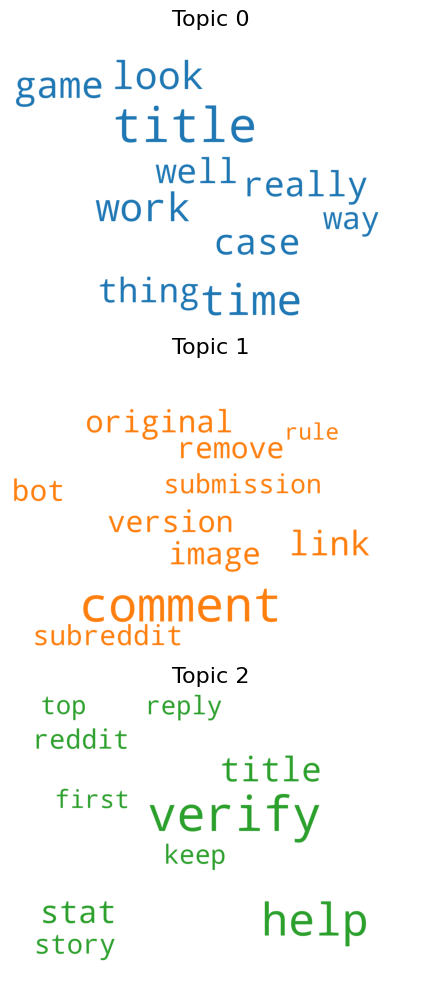

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 1, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


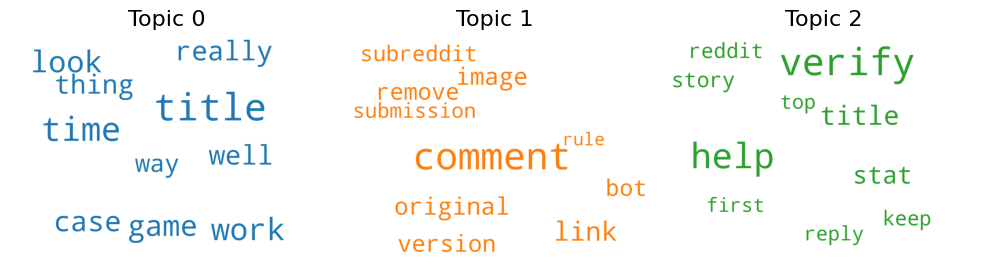

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Bots

In [ ]:
bots = full_data[full_data.Y == 0]
data_words = list(sent_to_words(bots.body.values))
len(data_words)

177238

In [ ]:
data_ready = process_words(data_words)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           #per_word_topics=True
                                            )

pprint(lda_model.print_topics())

[(0,
  '0.028*"verify" + 0.022*"help" + 0.017*"version" + 0.016*"stat" + '
  '0.013*"mobile" + 0.010*"text" + 0.007*"game" + 0.006*"people" + '
  '0.006*"time" + 0.005*"info"'),
 (1,
  '0.080*"post" + 0.039*"comment" + 0.022*"link" + 0.021*"remove" + '
  '0.021*"rule" + 0.020*"reply" + 0.018*"feel" + 0.016*"free" + '
  '0.014*"subreddit" + 0.014*"image"'),
 (2,
  '0.065*"comment" + 0.032*"link" + 0.032*"original" + 0.032*"title" + '
  '0.025*"submission" + 0.025*"post" + 0.023*"bot" + 0.021*"image" + '
  '0.019*"mirror" + 0.018*"subreddit"')]


In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

<ipython-input-40-83fff1afa991>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-40-83fff1afa991>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.3333,"verify, help, version, stat, mobile, text, gam...",[]
1,1,0,0.8666,"verify, help, version, stat, mobile, text, gam...","[verify, fuctarp, beecoin, help]"
2,2,0,0.7777,"verify, help, version, stat, mobile, text, gam...","[super, cute]"
3,3,0,0.7777,"verify, help, version, stat, mobile, text, gam...","[verify, acidyo]"
4,4,1,0.4525,"post, comment, link, remove, rule, reply, feel...","[last, comment, submission, reddit, limit, act..."
5,5,2,0.6667,"comment, link, original, title, submission, po...",[preview]
6,6,2,0.9545,"comment, link, original, title, submission, po...","[purpose, improve, timeliness, accuracy, respo..."
7,7,0,0.3333,"verify, help, version, stat, mobile, text, gam...",[]
8,8,2,0.9545,"comment, link, original, title, submission, po...","[purpose, improve, timeliness, accuracy, respo..."
9,9,1,0.9255,"post, comment, link, remove, rule, reply, feel...","[due, post, reddit, screenshot, website, feel,..."


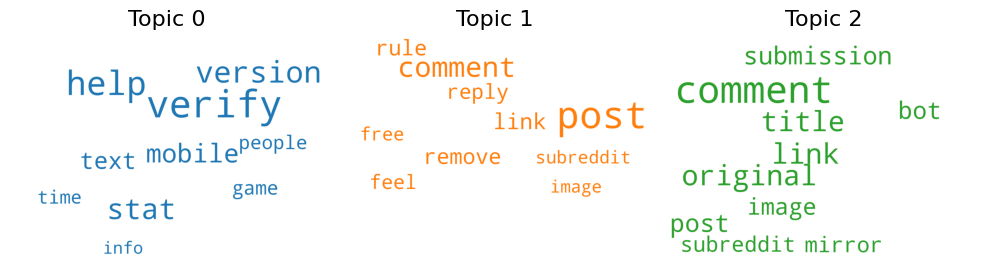

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Trolls

In [ ]:
trolls = full_data[full_data.Y == 1]
data_words = list(sent_to_words(trolls.body.values))
len(data_words)

6552

In [ ]:
data_ready = process_words(data_words)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           #per_word_topics=True
                                            )

pprint(lda_model.print_topics())

[(0,
  '0.016*"people" + 0.006*"life" + 0.006*"guy" + 0.005*"black" + 0.005*"time" '
  '+ 0.004*"old" + 0.004*"police" + 0.004*"work" + 0.004*"never" + '
  '0.004*"problem"'),
 (1,
  '0.008*"job" + 0.007*"great" + 0.007*"way" + 0.007*"pretty" + 0.006*"day" + '
  '0.006*"people" + 0.005*"news" + 0.005*"buy" + 0.005*"post" + 0.004*"still"'),
 (2,
  '0.010*"really" + 0.008*"time" + 0.007*"look" + 0.007*"bad" + 0.006*"thing" '
  '+ 0.006*"tie" + 0.006*"buy" + 0.006*"well" + 0.006*"much" + 0.005*"happen"')]


In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

<ipython-input-40-83fff1afa991>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-40-83fff1afa991>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.4791,"job, great, way, pretty, day, people, news, bu...","[kiss, meat]"
1,1,1,0.9007,"job, great, way, pretty, day, people, news, bu...","[communist, takeover, bourgeois, revolution, d..."
2,2,1,0.8353,"job, great, way, pretty, day, people, news, bu...","[cheap, add, new, ingridient, part, big]"
3,3,0,0.8616,"people, life, guy, black, time, old, police, w...","[still, apply, policy, way, life]"
4,4,0,0.7988,"people, life, guy, black, time, old, police, w...","[businessman, business, man]"
5,5,1,0.9120,"job, great, way, pretty, day, people, news, bu...","[least, eat, apple, day, keep, doctor, away]"
6,6,2,0.6657,"really, time, look, bad, thing, tie, buy, well...",[hodl]
7,7,1,0.6047,"job, great, way, pretty, day, people, news, bu...","[sell, xlm, bag, loss, move, amb, tie, price, ..."
8,8,0,0.3333,"people, life, guy, black, time, old, police, w...",[]
9,9,2,0.7615,"really, time, look, bad, thing, tie, buy, well...","[wait, hl]"


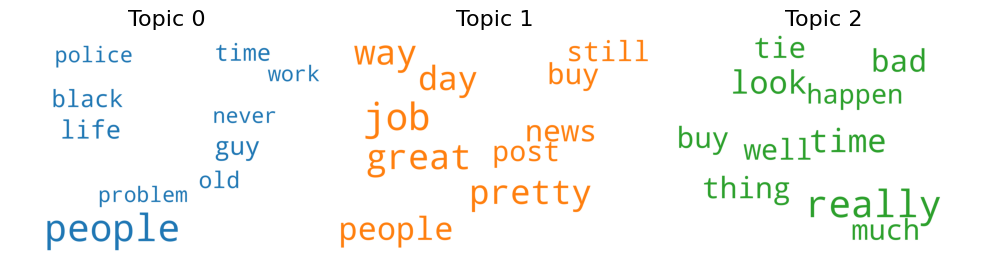

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Normal comments

In [ ]:
norms = full_data[full_data.Y == 2]
data_words = list(sent_to_words(norms.body.values))
len(data_words)

44822

In [ ]:
data_ready = process_words(data_words)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           #per_word_topics=True
                                            )

pprint(lda_model.print_topics())

[(0,
  '0.014*"post" + 0.011*"remove" + 0.009*"question" + 0.008*"people" + '
  '0.006*"comment" + 0.005*"add" + 0.005*"action" + 0.005*"link" + '
  '0.004*"read" + 0.004*"rule"'),
 (1,
  '0.012*"game" + 0.009*"play" + 0.008*"year" + 0.008*"time" + 0.007*"well" + '
  '0.006*"guy" + 0.006*"day" + 0.006*"much" + 0.005*"way" + 0.005*"thing"'),
 (2,
  '0.011*"delete" + 0.009*"people" + 0.009*"really" + 0.008*"work" + '
  '0.007*"time" + 0.006*"look" + 0.006*"thing" + 0.006*"well" + '
  '0.005*"actually" + 0.005*"way"')]


In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

<ipython-input-40-83fff1afa991>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-40-83fff1afa991>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,0.5330,"delete, people, really, work, time, look, thin...","[sound, toxic, situation, start, figure, move,..."
1,1,2,0.6667,"delete, people, really, work, time, look, thin...",[delete]
2,2,2,0.6667,"delete, people, really, work, time, look, thin...",[delete]
3,3,2,0.8162,"delete, people, really, work, time, look, thin...","[find, keyne, specific, detail, eugenic, gener..."
4,4,0,0.4711,"post, remove, question, people, comment, add, ...","[people, marry, spaceship]"
5,5,2,0.8385,"delete, people, really, work, time, look, thin...","[airline, choice, put, expense, free, roundtri..."
6,6,0,0.3333,"post, remove, question, people, comment, add, ...",[]
7,7,0,0.8235,"post, remove, question, people, comment, add, ...","[guy, talk, obnoxious, comment, thread, comple..."
8,8,2,0.7011,"delete, people, really, work, time, look, thin...","[lad, work, extra, player, improvement]"
9,9,0,0.3333,"post, remove, question, people, comment, add, ...",[]


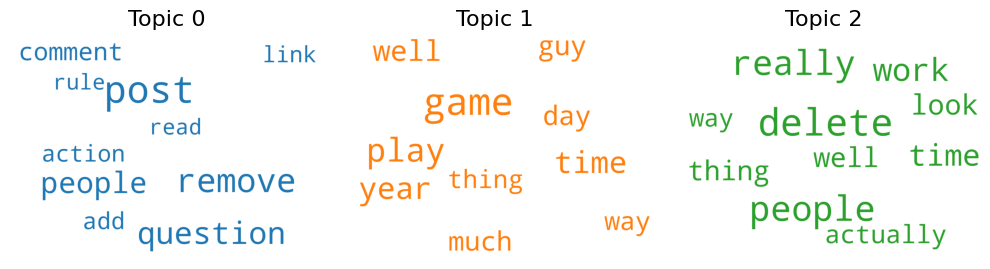

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Добавление новых признаков в таблицу + LogReg

In [ ]:
#pip install --upgrade ipykernel

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
result = pd.concat([full_data,df_dominant_topic], axis=1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
result.drop('Document_No', axis = 1, inplace = True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
result.to_csv('drive/MyDrive/Diplom/data_LDA.csv', sep='\t', index=False)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
result

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,link_id,author,score,body,ups,Y,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,t3_3qlmxn,yes_it_is_weird,3,#,3,0,0,0.3333,"title, time, work, look, game, case, really, w...",[]
1,1,t3_1y9uao,beecointipbot,1,^__[Verified]__: ^/u/fuctarp ^-&gt; ^/u/i_eatP...,1,0,2,0.8666,"verify, help, title, stat, story, reddit, keep...","[verify, fuctarp, beecoin, help]"
2,2,t3_anilqj,Nidalee_Bot,8,It's super cute.,8,0,0,0.7774,"title, time, work, look, game, case, really, w...","[super, cute]"
3,3,t3_1yg8os,BELITipBot,3,^__[Verified]__: ^/u/Acidyo ^-&gt; ^/u/Xaldos ...,3,0,2,0.6948,"verify, help, title, stat, story, reddit, keep...","[verify, acidyo]"
4,4,t3_2xn3f6,CHART_BOT,1,Statistics generated from Samuri_Kni's last 99...,1,0,1,0.9138,"comment, link, image, original, version, remov...","[last, comment, submission, reddit, limit, act..."
...,...,...,...,...,...,...,...,...,...,...,...
228607,228607,t3_2ntbb3,hockey_gif_bot,16,HTML5 Video [Desktop version](http://fitbamob....,16,0,1,0.7778,"comment, link, image, original, version, remov...","[version, mobile]"
228608,228608,t3_21b46o,coinflipbot,7,"I flipped a coin for you, /u/WogButter The res...",7,0,1,0.9028,"comment, link, image, original, version, remov...","[result, reply, comment, respond, comment, alone]"
228609,228609,t3_4p9jhl,Longboxjockey,5,"*But enough foreplay, Batsy. It's time for the...",5,2,0,0.8884,"title, time, work, look, game, case, really, w...","[enough, foreplay, batsy, time, show]"
228610,228610,t3_7uq458,d3posterbot,1,*I am a bot. But I still have feelings. Especi...,1,0,0,0.8736,"title, time, work, look, game, case, really, w...","[still, human, course, idea, new, expansion, g..."


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

def metrics(y_test, y_pred):
  
  conf = confusion_matrix(y_test, y_pred)
  print(conf)
  print(classification_report(y_test, y_pred,zero_division=0))
  print('f1_score_macro:', f1_score(y_test, y_pred, average='macro'))
  print('f1_score_micro:', f1_score(y_test, y_pred, average='micro'))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
cols = ['score', 'ups','Dominant_Topic', 'Topic_Perc_Contrib', 'Y']
col = ['score', 'ups','Dominant_Topic', 'Topic_Perc_Contrib']
df = result[cols]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
bots = df[df.Y == 0]
trolls = df[df.Y == 1]
norms = df[df.Y == 2]

train = pd.concat([bots[1000:], trolls[1000:], norms[1000:]], ignore_index=True)

X_train = train[col]
y_train = train['Y'].values

test = pd.concat([bots[:1000], trolls[:1000], norms[:1000]], ignore_index=True)

X_test = test[col]
y_test = test['Y'].values

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pipel = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500, class_weight = 'balanced'))

pipel.fit(X_train, y_train)

y_pred = pipel.predict(X_test)

metrics(y_test, y_pred)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[594 354  52]
 [148 729 123]
 [137 492 371]]
              precision    recall  f1-score   support

           0       0.68      0.59      0.63      1000
           1       0.46      0.73      0.57      1000
           2       0.68      0.37      0.48      1000

    accuracy                           0.56      3000
   macro avg       0.61      0.56      0.56      3000
weighted avg       0.61      0.56      0.56      3000

f1_score_macro: 0.5594710144120092
f1_score_micro: 0.5646666666666667
